Manifold Learning with Isomap
=============================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This tour explores the Isomap algorithm for manifold learning.


The <http://waldron.stanford.edu/~isomap/ Isomap> algorithm is introduced in


_A Global Geometric Framework for Nonlinear Dimensionality Reduction,_
J. B. Tenenbaum, V. de Silva and J. C. Langford,
Science 290 (5500): 2319-2323, 22 December 2000.

In [1]:
from __future__ import division

import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *
#from nt_solutions import shapes_7_isomap as solutions

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

Graph Approximation of Manifolds
--------------------------------
Manifold learning consist in approximating the parameterization of a
manifold represented as a point cloud.


First we load a simple 3D point cloud, the famous Swiss Roll.


Number of points.

In [2]:
n = 1000

Random position on the parameteric domain.

In [3]:
from numpy import random
x = random.rand(2,n)

Mapping on the manifold.

In [4]:
v = 3*np.pi/2*(.1 + 2*x[0,:])
X  = np.zeros([3,n])
X[1,:] = 20*x[1,:]
X[0,:] = - np.cos(v)*v
X[2,:] = np.sin(v)*v

Parameter for display.

In [5]:
ms = 200
el = 20; az = -110

Display the point cloud.

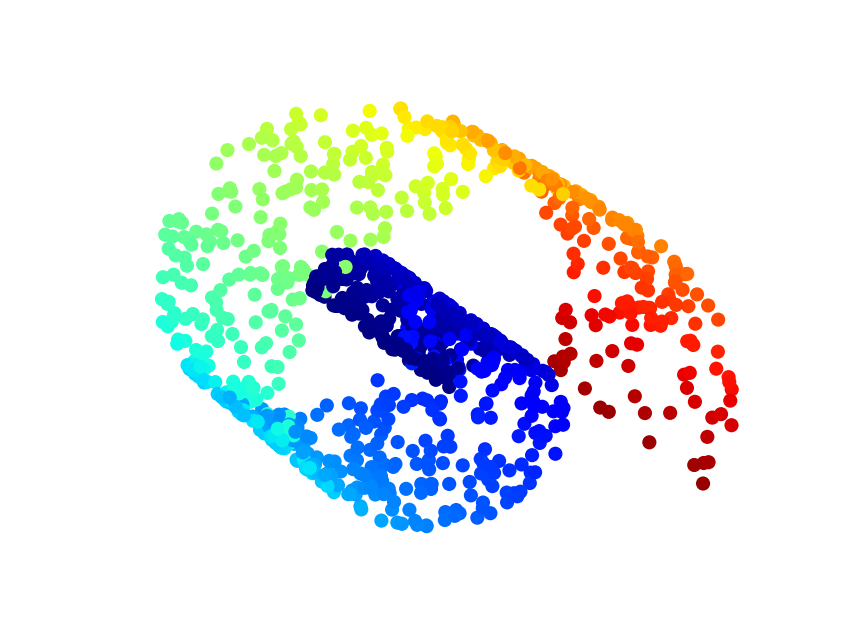

In [6]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,11))
ax = fig.add_subplot(111, projection="3d")

#swiss roll
ax.scatter(X[0,:], X[1,:], X[2,:], c=plt.cm.jet((X[0,:]**2+X[2,:]**2)/100), s=ms, lw=0, alpha=1)

#params
ax.set_xlim(np.min(X[0,:]),np.max(X[0,:]))
ax.set_ylim(np.min(X[1,:]),np.max(X[1,:]))
ax.set_zlim(np.min(X[2,:]),np.max(X[2,:]))
ax.axis("off")
ax.view_init(elev=el, azim=az)

Compute the pairwise Euclidean distance matrix.

In [7]:
D1 = np.repeat(np.sum(X**2, 0)[:,np.newaxis], n, 1)
D1 = np.sqrt(D1 + np.transpose(D1) - 2*np.dot(np.transpose(X), X))

Number of NN for the graph.

In [8]:
k = 6

Compute the k-NN connectivity.

In [9]:
DNN, NN = np.sort(D1), np.argsort(D1)
NN = NN[:,1:k+1]
DNN = DNN[:,1:k+1]

Adjacency matrix, and weighted adjacency.

In [10]:
from scipy import sparse

B = np.tile(np.arange(0,n),(k,1))
A = sparse.coo_matrix((np.ones(k*n),(np.ravel(B, order="F"), np.ravel(NN))))

Weighted adjacency (the metric on the graph).

In [11]:
W = sparse.coo_matrix((np.ravel(DNN),(np.ravel(B, order="F"), np.ravel(NN))))

Display the graph.

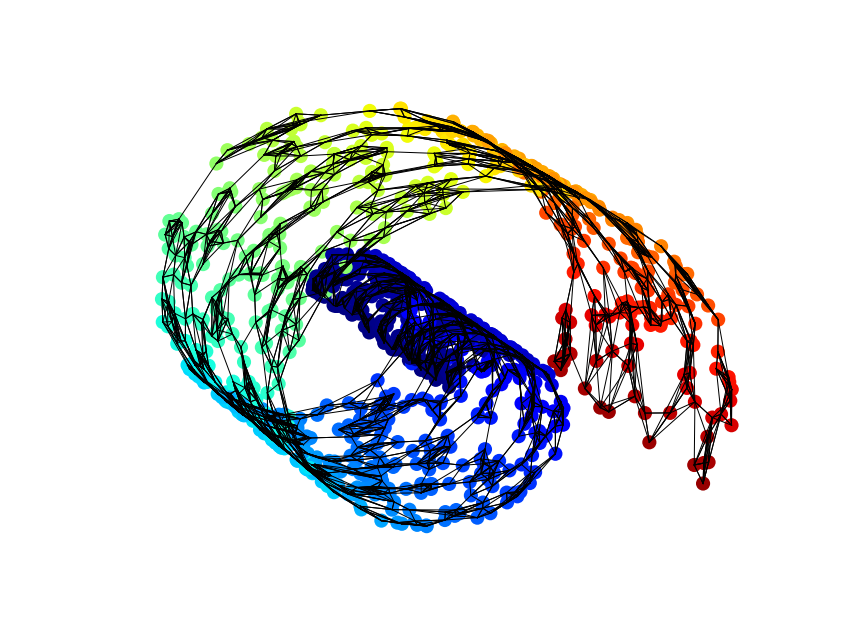

In [12]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,11))
ax = fig.add_subplot(111, projection="3d")

#swiss roll
ax.scatter(X[0,:], X[1,:], X[2,:], c=plt.cm.jet((X[0,:]**2+X[2,:]**2)/100), s=ms, lw=0, alpha=1)

#graph
I,J,V = sparse.find(A)
xx = np.vstack((X[0,I],X[0,J]))
yy = np.vstack((X[1,I],X[1,J]))
zz = np.vstack((X[2,I],X[2,J]))

for i in range(len(I)):
    ax.plot(xx[:,i], yy[:,i], zz[:,i], color="black")

#params
ax.axis("off")
ax.set_xlim(np.min(X[0,:]),np.max(X[0,:]))
ax.set_ylim(np.min(X[1,:]),np.max(X[1,:]))
ax.set_zlim(np.min(X[2,:]),np.max(X[2,:]))
ax.view_init(elev=el, azim=az)

plt.show()

Floyd Algorithm to Compute Pairwise Geodesic Distances
------------------------------------------------------
A simple algorithm to compute the geodesic distances between all pairs of
points on a graph is Floyd iterative algorithm. Its complexity is
$\mathcal O(n^3)$ where $n$ is the number of points. It is thus quite slow for
sparse graph, where Dijkstra runs in $\mathcal O(n^2\log(n))$.


Floyd algorithm iterates the following update rule, for $k=1,\dots,n$


$D(i,j) \leftarrow \min(D(i,j), D(i,k)+D(k,j))$,


with the initialization $D(i,j)=W(i,j)$ if $W(i,j)>0$, and
$D(i,j)=Inf$ if $W(i,j)=0$.


Make the graph symmetric.

In [13]:
D = W.toarray()
D = (D + np.transpose(D))/2.

Initialize the matrix.

In [14]:
D[D == 0] = np.float("inf")

Add connexion between a point and itself.

In [15]:
D = D - np.diag(np.diag(D))
D[np.isnan(D)] = np.float("inf")

__Exercise 1__

Implement the Floyd algorithm to compute the full distance matrix
$D$, where $D(i,j)$ is the geodesic distance between

In [16]:
#solutions.exo1()

In [17]:
## Insert your code here.

for i in range(n):
    D = np.minimum(D, np.tile(D[:,i][:,np.newaxis], (1,n)) + np.tile(D[i,:], (n,1)))

Find index of vertices that are not connected to the main manifold.

In [18]:
Iremove = np.where(D[:,0] == np.float("Inf"))

Remove Inf remaining values (disconnected components).

In [19]:
D[D == np.float("Inf")] = 0

Isomap with Classical Multidimensional Scaling
----------------------------------------------
Isomap perform the dimensionality reduction by applying multidimensional
scaling.


Please refers to the tours on Bending Invariant for detail on
Classical MDS (strain minimization).

__Exercise 2__

Perform classical MDS to compute the 2D flattening.

In [20]:
#solutions.exo2()

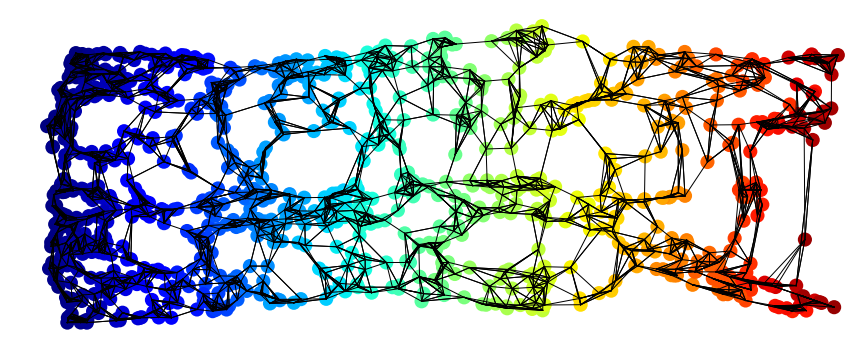

In [21]:
## Insert your code here.

from numpy import linalg

J = np.identity(n) - np.ones([n,n])/n
K = -1/2.*np.dot(J,np.dot(D**2,J))

[val, Xstrain] = sparse.linalg.eigs(K, k=2, which='LR')

Xstrain = Xstrain*np.tile(np.sqrt(val), (n,1))
Xstrain = np.real(np.transpose(Xstrain))

#plot size
plt.figure(figsize = (15,6))

#plot points
plt.scatter(Xstrain[0,:], Xstrain[1,:], ms, c=plt.cm.jet((X[0,:]**2+X[2,:]**2)/100), lw=0, alpha=1)

#plot vertices
I,J,V = sparse.find(A)
xx = np.vstack((Xstrain[0,I], Xstrain[0,J]))
yy = np.vstack((Xstrain[1,I], Xstrain[1,J]))

for i in range(len(I)):
    plt.plot(xx[:,i], yy[:,i], color="black")
    
#params
plt.axis("off")
plt.xlim(np.min(Xstrain[0,:]-1),np.max(Xstrain[0,:])+1)
plt.ylim(np.min(Xstrain[1,:]-1),np.max(Xstrain[1,:])+1)

plt.show()

Redess the points using the two leading eigenvectors of the covariance
matrix (PCA correction).

In [22]:
[L, U] = linalg.eig(np.dot(Xstrain, np.transpose(Xstrain))/n)
Xstrain1 = np.dot(np.transpose(U), Xstrain)

Remove problematic points.

In [23]:
Xstrain1[:,Iremove] = np.float("inf")

Display the final result of the dimensionality reduction.

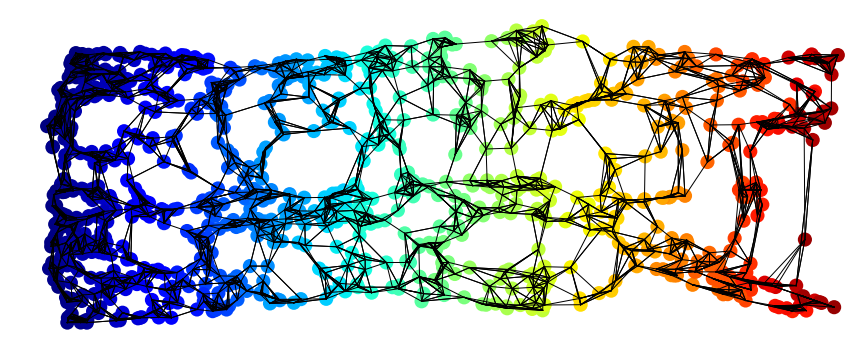

In [24]:
#plot size
plt.figure(figsize = (15,6))

#plot points
plt.scatter(Xstrain1[0,:], Xstrain1[1,:], ms, c=plt.cm.jet((X[0,:]**2+X[2,:]**2)/100), lw=0, alpha=1)

#plot vertices
I,J,V = sparse.find(A)
xx = np.vstack((Xstrain1[0,I], Xstrain1[0,J]))
yy = np.vstack((Xstrain1[1,I], Xstrain1[1,J]))

for i in range(len(I)):
    plt.plot(xx[:,i], yy[:,i], color="black")
    
#params
plt.axis("off")
plt.xlim(np.min(Xstrain1[0,:]-1),np.max(Xstrain1[0,:])+1)
plt.ylim(np.min(Xstrain1[1,:]-1),np.max(Xstrain1[1,:])+1)

plt.show()

For comparison, the ideal locations on the parameter domain.

In [25]:
Y = np.vstack((v, X[1,:]))
Y[0,:] = rescale(Y[0,:], min(Xstrain[0,:]), max(Xstrain[0,:]))
Y[1,:] = rescale(Y[1,:], min(Xstrain[1,:]), max(Xstrain[1,:]))

Display the ideal graph on the reduced parameter domain.

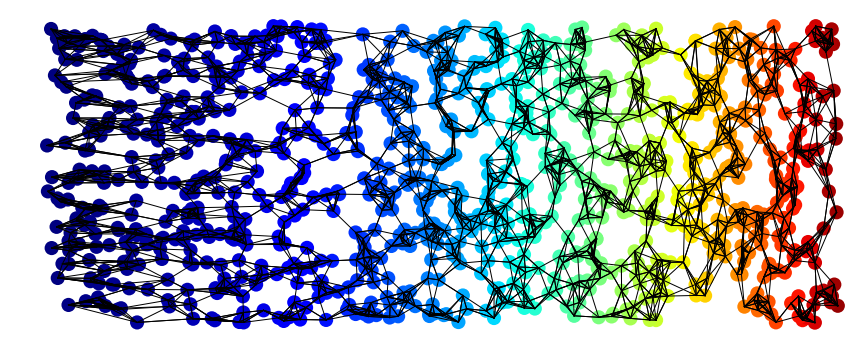

In [26]:
#plot size
plt.figure(figsize = (15,6))

#plot points
plt.scatter(Y[0,:], Y[1,:], ms, c=plt.cm.jet((X[0,:]**2+X[2,:]**2)/100), lw=0, alpha=1)

#plot vertices
I,J,V = sparse.find(A)
xx = np.vstack((Y[0,I], Y[0,J]))
yy = np.vstack((Y[1,I], Y[1,J]))

for i in range(len(I)):
    plt.plot(xx[:,i], yy[:,i], color="black")
    
#params
plt.axis("off")
plt.xlim(np.min(Y[0,:]-1),np.max(Y[0,:])+1)
plt.ylim(np.min(Y[1,:]-1),np.max(Y[1,:])+1)

plt.show()

Isomap with SMACOF Multidimensional Scaling
-------------------------------------------
It is possible to use SMACOF instead of classical scaling.


Please refers to the tours on Bending Invariant for detail on both
Classical MDS (strain minimization) and SMACOF MDS (stress minimization).

__Exercise 3__

Perform stress minimization MDS using SMACOF to compute the 2D flattening.

In [27]:
#solutions.exo3()

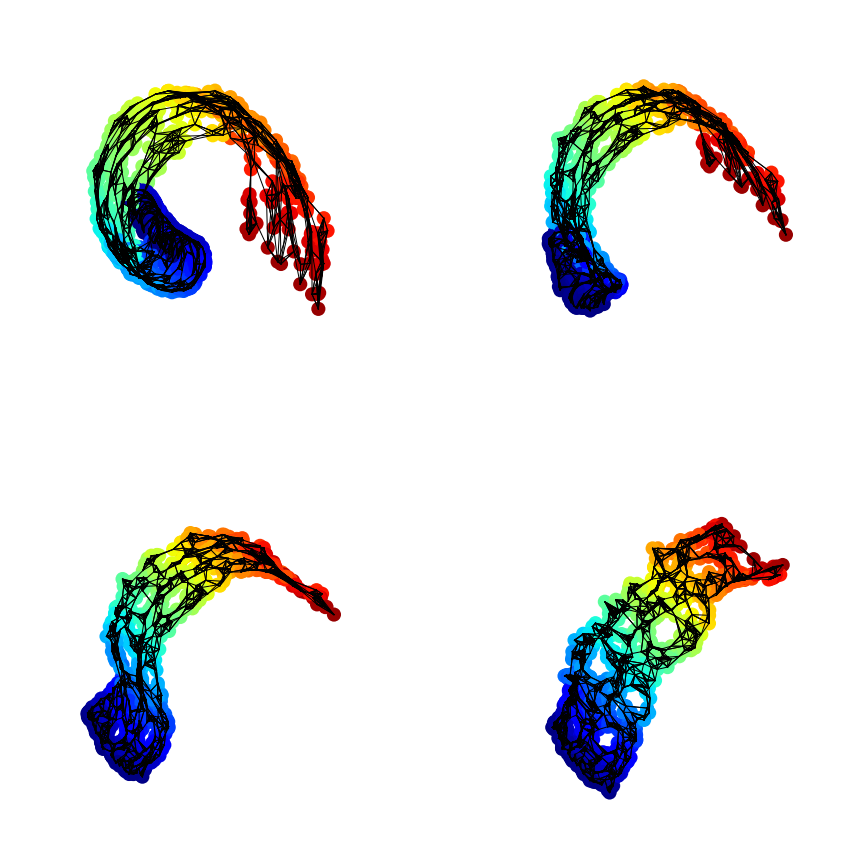

In [28]:
## Insert your code here.

fig = plt.figure(figsize=(15,15))
niter = 150;
stress = []
Xstress = np.copy(X)
ndisp = [1, 5, 10, min(niter,100), np.float("Inf")]
k = 0

for i in range(niter):

    if ndisp[k] == i:
        ax = fig.add_subplot(2, 2, k+1, projection="3d")
        
        #swiss roll
        ax.scatter(Xstress[0,:], Xstress[1,:], Xstress[2,:], c=plt.cm.jet((X[0,:]**2+X[2,:]**2)/100), s=ms, lw=0, alpha=1)
        
        #graph
        I,J,V = sparse.find(A)
        xx = np.vstack((Xstress[0,I],Xstress[0,J]))
        yy = np.vstack((Xstress[1,I],Xstress[1,J]))
        zz = np.vstack((Xstress[2,I],Xstress[2,J]))
        
        for i in range(len(I)):
            ax.plot(xx[:,i], yy[:,i], zz[:,i], color="black")
        
        #params
        ax.axis("off")
        ax.set_xlim(np.min(Xstress[0,:]),np.max(Xstress[0,:]))
        ax.set_ylim(np.min(Xstress[1,:]),np.max(Xstress[1,:]))
        ax.set_zlim(np.min(Xstress[2,:]),np.max(Xstress[2,:]))
        ax.view_init(elev=el, azim=az)
        
        k += 1

    # Compute the distance matrix.
    D1 = np.repeat(np.sum(Xstress**2, 0)[:,np.newaxis], n, 1)
    D1 = np.sqrt(D1 + np.transpose(D1) - 2*np.dot(np.transpose(Xstress), Xstress))
    
    # Compute the scaling matrix.
    B = -D/np.maximum(D1,1e-10*np.ones(np.shape(D1)))
    B = B - np.diag(np.sum(B,0))
    
    # update
    Xstress = np.transpose(np.dot(B, np.transpose(Xstress)))/n
    # Xstress = Xstress-repmat(mean(Xstress,2), [1 n]);
    # record stress
    stress = stress + [np.sqrt(np.sum(abs(D-D1)**2)/n**2)]

plt.show()

Plot stress evolution during minimization.

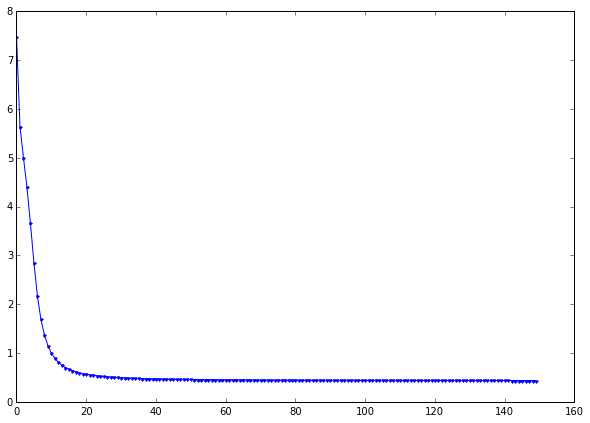

In [29]:
plt.figure(figsize=(10,7))
plt.plot(stress, '.-')
plt.show()

Compute the main direction of the point clouds.

In [30]:
[L, U] = linalg.eig(np.dot(Xstress, np.transpose(Xstress))/n)
[L, I] = np.sort(L), np.argsort(L)
U = U[:,I[1:3]]

Project the points on the two leading eigenvectors of the covariance
matrix (PCA final projection).

In [31]:
Xstress1 = np.dot(np.transpose(U), Xstress)

Remove problematic points.

In [32]:
Xstress1[:,Iremove] = np.float("Inf")

Display the final result of the dimensionality reduction.

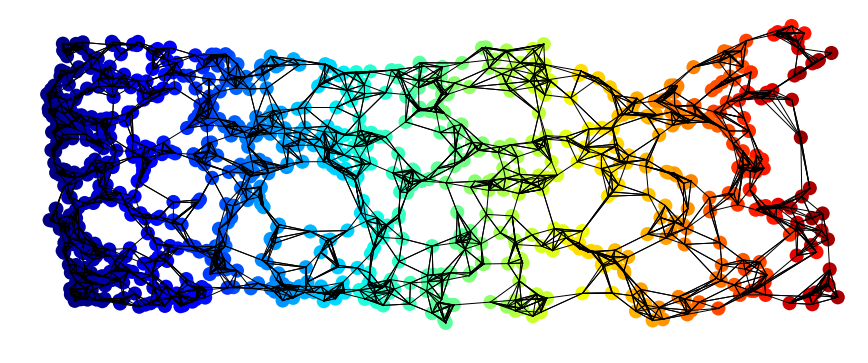

In [33]:
#plot size
plt.figure(figsize = (15,6))

#plot points
plt.scatter(Xstress1[1,:], Xstress1[0,:], ms, c=plt.cm.jet((X[0,:]**2+X[2,:]**2)/100), lw=0, alpha=1)

#plot vertices
I,J,V = sparse.find(A)
xx = np.vstack((Xstress1[1,I], Xstress1[1,J]))
yy = np.vstack((Xstress1[0,I], Xstress1[0,J]))

for i in range(len(I)):
    plt.plot(xx[:,i], yy[:,i], color="black")
    
#params
plt.axis("off")
plt.xlim(np.min(Xstress1[1,:]-1),np.max(Xstress1[1,:])+1)
plt.ylim(np.min(Xstress1[0,:]-1),np.max(Xstress1[0,:])+1)

plt.show()